<a href="https://colab.research.google.com/github/Steve-YJ/deep-learning-from-scratch-studying/blob/master/Tu_DataLoader_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom Dataset, DataLoader, Transforms 작성하기

* Reference: https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html
* Goal
    * How to make Custom DataLoader
    * Especially Transforms!!

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 경고 메세지 무시하기
import warnings
plt.ion()  # 반응형 모드

* Download Data: [data set(Click here)](https://download.pytorch.org/tutorial/faces.zip)
* data/faces

In [3]:
# landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

In [4]:
# copy from Exp02. run_GAN

# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# FOLDERNAME = '/Malimg_Exp_200611'

# assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive/Torch-Tutorial
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd /Malimg_Exp_200611/
# !bash get_datasets.sh
# %cd ../../
! pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Torch-Tutorial
/content/drive/My Drive/Torch-Tutorial


In [5]:
landmark_frame = pd.read_csv('data/faces/face_landmarks.csv')
landmark_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,220,89,238,108,255,129,268,155,268,180,261,203,244,222,224,238,199,247,172,248,144,245,116,241,87,39,114,45,102,57,...,98,207,107,199,120,193,131,193,142,188,162,185,184,187,168,206,151,218,139,222,127,223,113,219,103,206,122,203,133,201,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,536,186,567,214,594,249,614,290,616,329,608,363,589,390,562,411,529,421,491,425,450,425,409,423,370,162,345,178,330,200,...,228,514,246,502,264,495,278,499,292,495,315,502,341,511,318,530,297,538,281,539,266,537,248,529,239,513,265,507,278,509,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,238,103,257,117,274,134,287,154,290,176,287,197,276,218,263,235,247,246,227,251,205,253,181,254,157,91,136,98,127,112,...,116,224,127,221,140,221,149,223,160,220,177,220,195,224,179,238,163,244,152,245,141,244,129,239,120,225,140,225,150,226,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,107,41,116,50,122,61,126,72,127,83,126,95,123,107,119,115,111,118,101,120,91,122,80,122,68,39,52,45,46,53,...,55,98,63,96,70,94,75,95,80,94,86,95,94,99,86,103,79,105,74,105,69,105,62,103,58,99,70,98,74,98,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,121,91,129,98,136,106,142,115,144,125,142,134,137,142,130,149,122,153,113,154,102,155,91,156,79,84,75,87,71,93,...,96,114,102,112,109,112,114,114,119,112,126,112,134,113,127,122,120,126,114,126,109,126,102,122,99,115,109,115,114,116,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,134,54,142,61,148,70,152,80,154,90,153,99,149,107,143,113,135,117,126,119,115,121,104,122,93,49,83,54,79,60,...,66,130,72,127,77,125,81,126,85,125,90,127,96,130,90,132,85,134,81,134,77,133,71,133,68,130,77,130,81,130,85,130,94,130,85,128,81,12

In [7]:
n = 65
img_name = landmark_frame.iloc[n, 0]
landmarks = landmark_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


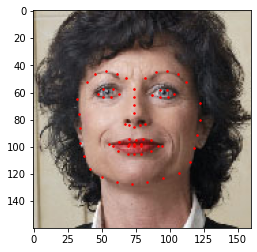

In [9]:
# 이미지와 랜드마크(landmark)를 보여주는 간단한 함수를 작성해보고, 실제 적용해보자

def show_landmarks(image, landmarks):
    """show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 갱신이 되도록 잠시 멈춤

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

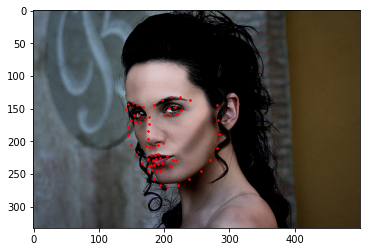

In [14]:
# 이미지와 랜드마크(landmark)를 보여주는 간단한 함수를 작성해보고, 실제 적용해보자

img_name = landmark_frame.iloc[10, 0]
landmarks = landmark_frame.iloc[10, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

def show_landmarks(image, landmarks):
    """show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 갱신이 되도록 잠시 멈춤

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

## Dataset 클래스

<code>torch.utils.data.Dataset</code>은 데이터셋을 나타내는 추상클래스이다. 우리의 데이터셋은 Dataset을 상속하고 아래와 같이 오버라이드를 해야한다.

* len(dataset)
* dataset[i]

데이터셋 샘플은 {'image': image, 'landmarks': landmarks}의 사전 형태를 갖는다<br>
선택적 인자인 transform을 통해 필요한 전처리 과정을 샘플에 적용할 수 있다.

In [40]:
## Dataset 클래스

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로
            root_dir (string): 모든 이미지가 존재하는 디렉터리 경로
            transform (callable, optional): 샘플에 적용될 Optional transform
        
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                  self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

위에서 정의한 클래스를 인스턴스화하고 데이터 샘플을 통해 반복해보자. <br>
첫 번째 4개의 샘플의 크기를 출력하고, 샘플들의 랜드마크들을 보여줄 것이다

0 (324, 215, 3) (68, 2)


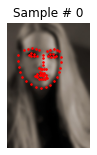

1 (500, 333, 3) (68, 2)


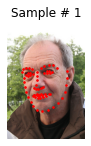

2 (250, 258, 3) (68, 2)


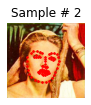

3 (434, 290, 3) (68, 2)


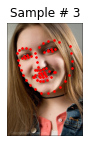

In [33]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

# face_dataset

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample # {}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## Transforms

* 위에서 볼 수 있는 문제점
    * 샘플이 다 같은 사이즈가 아니다
    * 신경망(Neural Network)은 고정된 크기의 이미지를 가정한다
    * 신경망에 주기 전 전처리를 할 필요가 있다

* 3가지 transforms을 만들어보자
    * Data augmentation
        * <code>Rescale</code>: 이미지의 크기 조정
        * <code>RandomCrop</code>: 이미지를 무작위로 자름
    * <code>ToTensor</code>: numpy 이미지에서 torch 이미지로 변경(축변환 필요)(we need to swap axes)


* 간단한 함수 대신 호출할 수 있는 클래스로 작성
* 클래스가 호출될때마다 전이(Transform)의 매개변수가 전달되지 않아도 된다 
* 이돠 같이 <code>__call__</code>함수를 구현해야한다.
* 필요하다면 <code>__init__</code>함수도 구현해야 한다

In [35]:
# tsfm = Transform(params)

In [37]:
class Rescale(object):
    """주어진 사이즈로 샘플크기를 조정합니다.

    Args:
        output_size(tuple or int) : 원하는 사이즈 값
            tuple인 경우 해당 tuple(output_size)이 결과물(output)의 크기가 되고,
            int라면 비율을 유지하면서, 길이가 작은 쪽이 output_size가 됩니다.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """샘플데이터를 무작위로 자릅니다.

    Args:
        output_size (tuple or int): 줄이고자 하는 크기입니다.
                        int라면, 정사각형으로 나올 것 입니다.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """numpy array를 tensor(torch)로 변환 시켜줍니다."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

* 이제 샘플에 transforom을 적용해보자

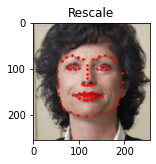

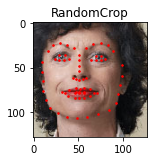

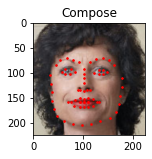

In [38]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [41]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


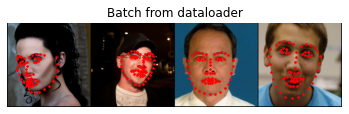

In [42]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# 배치하는 과정을 보여주는 함수입니다.
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break